In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns


from abc import ABC
from IPython.display import Image
from typing import Callable, Type

%matplotlib inline

## 0. Motivation. Monte-Carlo method

Let $p(T)$ be a given probability distribution (PDF). Monte Carlo Method (aka Monte Carlo Simulation) implies repeated **random sampling** from this distribution:
$$T_1, T_2, \dotsc, T_N\sim p(T)$$
How can it be useful?

1. Estimating expectations - $\displaystyle\mathbb{E}f(T)=\int\limits f(T)p(T)dT\approx\dfrac{1}{N}\sum\limits_{n=1}^Nf(T_n)$.
2. Estimating mode - $\displaystyle \max_\text{T}{p(T)}\approx\max_\text{n}{p(T_n)}$.

Here we should note that sometimes we know the density function up to some normalizing constant:
$$p(T)=\dfrac{1}{\alpha}\tilde{p}(T)$$

The main problem we discuss later is how to effectively generate sample $T_1, T_2, \dotsc, T_N$ from a distribution defined by its PDF $p(T)$ or its unnormalized PDF $\tilde{p}(T)$.

## 1. Elementary Sampling Techniques.

### Inversion Sampling

Assume one-dimensional random value X and its CDF $f(x)=\mathbb{P}\{X\leqslant x\}$.
\
Consider new random value $f(X)$. It is easy to show that $f(X)$ has standard (i.e. on $[0, 1]$) uniform distribution (prove it!). Here appears the primary sampling method - **inversion sampling**. First, we generate $\xi\sim U[0, 1]$ and then calculate our draw $x=f^{-1}(\xi)$.

Discrete distribution illustration:

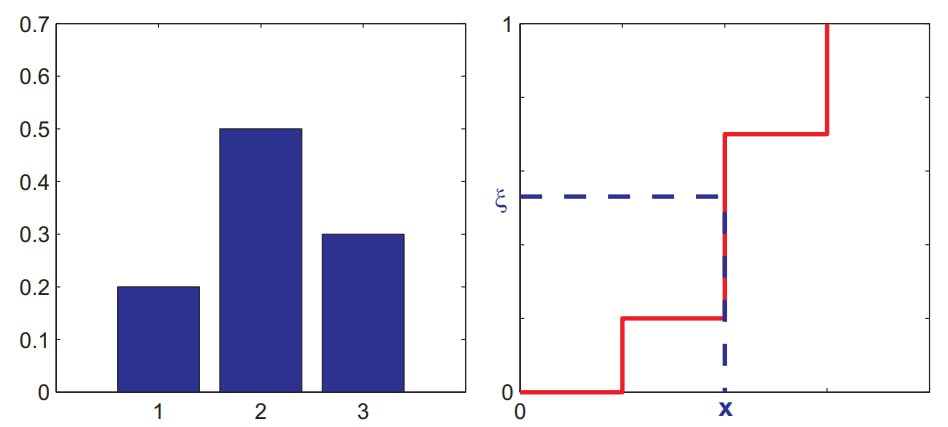

In [2]:
Image('inverse_discrete.jpeg', width=700)

Continious distribution illustration:

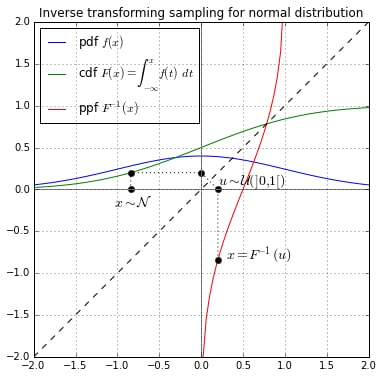

In [3]:
Image('inverse_normal.jpeg', width=400)

Inversion sampling, numerical example:

Consider Cauchy distribution:
$$p(x)=\dfrac{1}{\pi(1+x^2)}, \: f(x)=\dfrac{1}{\pi}\arctan{x}+\dfrac{1}{2}$$
$$\xi=f(x) \Leftrightarrow x=f^{-1}(\xi)=\tan\big(\pi(\xi-\dfrac{1}{2})\big)$$

Note that inversion sampling can be applied only in a limited number of cases as it requires calculating the inverse function for the cumulative distribution function. For example, this method can't be applied to normal distribution.

#### Exercise
Implement inversion sampling for discrete random values:

In [4]:
def discrete_inversion(prob_vec: np.ndarray) -> int:
    '''
    Implement inversion sampling for a discrete random value with probability vector
    (p1, p2, ..., pn) and possible outcomes (1, 2, ..., n) respectively.
    '''
    u = np.random.uniform()
    if u <= prob_vec[0]:
        return 1
    else:
        for i in range(1, len(prob_vec) + 1):
            if np.sum(prob_vec[0: i]) < u and np.sum(prob_vec[0: i + 1]) > u:
                return i + 1


def get_discrete_samples(prob_vec: np.ndarray, n: int = 1) -> np.ndarray:
    '''
    This function simply repeats the previous to generate an array of random variable samples.
    '''
    sample = []
    for i in range(n):
        sample.append(discrete_inversion(prob_vec))
    return np.array(sample)


def discrete_simulate(prob_vec: np.ndarray, n: int = 1) -> None:
    '''
    Simulate the result and compare it with the actual one.
    '''
    vals = np.arange(1, len(prob_vec) + 1)
    sample = get_discrete_samples(prob_vec, n)
    
    counts = [0] * len(prob_vec)
    for val in sample:
        counts[val - 1] += 1
    counts_theory = [0] * len(prob_vec)
    for i in range(n):
        val = np.random.choice(vals, 1, p=prob_vec)[0]
        counts_theory[val - 1] += 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.bar(vals, np.array(counts) / n)
    ax1.set_title(f'Inversion Sampling {n} Discrete Random Variables')
    ax2.bar(vals, np.array(counts_theory) / n)
    ax2.set_title(f'Simulation of Generating {n} Discrete Random Variables, Builtin Method')
    plt.show()

Check yourself:

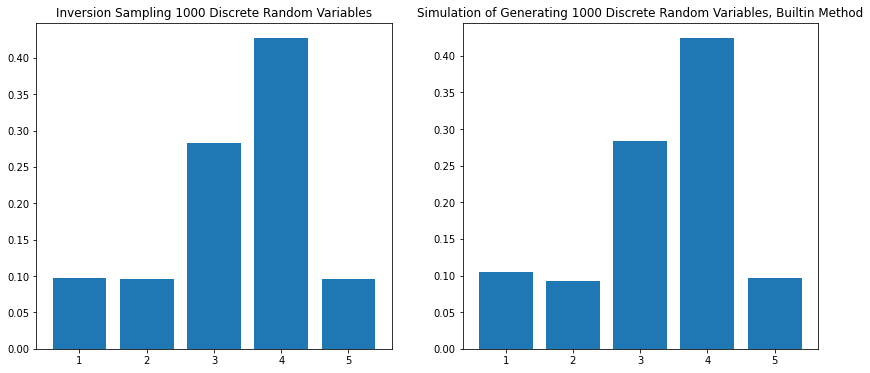

In [5]:
prob_vec = np.array([0.1, 0.1, 0.3, 0.4, 0.1])
discrete_simulate(prob_vec, n=1000)

### Rejection Sampling

Rejection sampling is a general technique that can be applied to almost any continious one-dimensional random variable. It works the following way:

Suppose we need to generate samples from some distribution with PDF equal to $\tilde{p}(x)$ which is known up to some normalizing constant. We take some known distribution $q(x)$ from which we are able to generate samples and that satisfies $\tilde{p}(x)\leqslant\tilde{q}(x)$. Here $\tilde{q}(x)$ represents unnormalized density $q(x)$. Now we generate $x_0\sim q(x)$, and then we generate $u_0\sim U[0, \tilde{q}(x_0)]$. As a result, set of pairs $(x_0, u_0)$ is a set of points uniformly distributed in the area under the $\tilde{q}(x)$ curve. We reject pairs $(x_0, u_0)$ such that $u_0>\tilde{p}(x_0)$. The pairs that are left will be uniformly distributed in the area under the $\tilde{p}(x)$ curve. Last, we forget about $u_0$ and obtain the sample derived from $p(x)$ distribution.

Illustration:

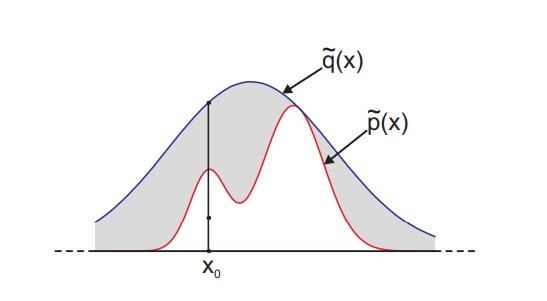

In [6]:
Image('rej.jpeg', width=700)

**Proof**

Here we prove that values $x$ obtained by the method discussed above will have PDF equal to $p(x)$. Assume $\int\limits_{-\infty}^{+\infty}\tilde{p}(x)dx=P$, $\int\limits_{-\infty}^{+\infty}\tilde{q}(x)dx=Q$.
$$F_x(x_0)=\mathbb{P}(x\leqslant x_0)=\mathbb{P}\big(x\leqslant x_0|u\leqslant\tilde{p}(x)\big)=\dfrac{\mathbb{P}\big(x\leqslant x_0, u\leqslant\tilde{p}(x)\big)}{\mathbb{P}\big(u\leqslant\tilde{p}(x)\big)}=$$
$$=\dfrac{\int\limits_0^{x_0}dx\int\limits_0^{\tilde{p}(x)}\frac{1}{Q}du}{\frac{P}{Q}}=\dfrac{\dfrac{1}{Q}\int\limits_0^{x_0}\tilde{p}(x)dx}{\frac{P}{Q}}=\dfrac{\dfrac{1}{Q}\int\limits_0^{x_0}Pp(x)dx}{\frac{P}{Q}}=\int\limits_0^{x_0}p(x)dx$$
By definition this means $x\sim p(x)$.

#### Exercise
Implement rejection sampling for mixture of two normal distributions - $\mathcal{N}(x|3, 1)$ and $\mathcal{N}(x|2, 2)$.

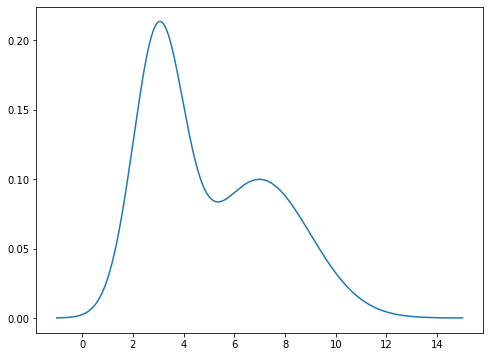

In [7]:
def p(x: float) -> float:
    return 0.5 * (st.norm.pdf(x, loc=3, scale=1) + st.norm.pdf(x, loc=7, scale=2))


fig, ax = plt.subplots(figsize=(8, 6))
x = np.linspace(-1, 15, 10000)
ax.plot(x, p(x))
plt.show()

In [8]:
def q(x):
    return st.norm.pdf(x, loc=5, scale=4)    # can take any you like


x = np.linspace(-50, 50, 10000)
c = 1.05 * max(p(x) / q(x))

Check that you've done everything right:

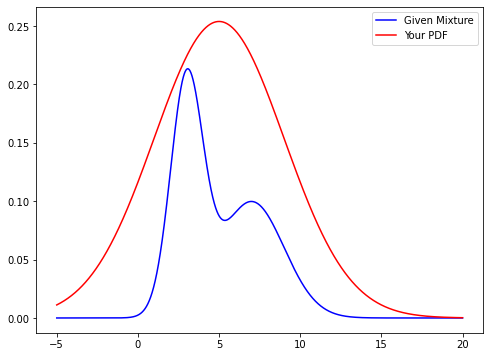

In [9]:
def check_your_q_and_c(q: Callable[[float], float], c: float) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    x = np.linspace(-5, 20, 10000)
    ax.plot(x, p(x), color='blue', label='Given Mixture')
    ax.plot(x, c * q(x), color='red', label='Your PDF')
    ax.legend(loc='best')
    plt.show()


check_your_q_and_c(q, c)

Now you are ready to implement rejection sampling using the $\tilde{q}(x)=cq(x)$ distribution you have just obtained.

In [10]:
def rejection_sampling(p: Callable[[float], float], q: Callable[[float], float],
                       c: float, n_samples: int) -> np.ndarray:
    '''
    Apply inversion sampling to sample from p(x) distribution using c*q(x) as an upper bound.
    '''
    samples = []
    
    for i in range(n_samples):
        x0 = np.random.normal(loc=5, scale=4)    # parameters may change subject to chosen function q(x)
        u = np.random.uniform(low=0, high=c*q(x0))
        if u <= p(x0):
            samples.append(x0)
    
    return np.array(samples)


def inversion_sampling_simulate(p: Callable[[float], float], q: Callable[[float], float],
                                c: float, n_samples: int) -> None:
    '''
    Nice plotting function to simulate your algo.
    '''
    samples = rejection_sampling(p, q, c, n_samples)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.distplot(ax=ax, a=samples)
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


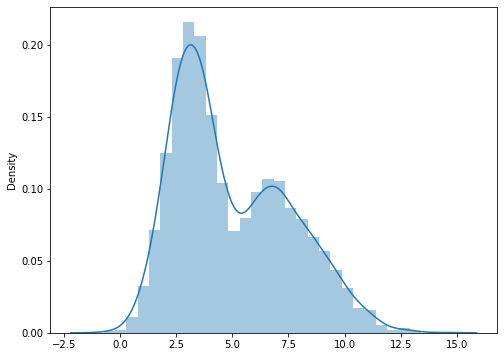

In [11]:
inversion_sampling_simulate(p=p, q=q, c=c, n_samples=10000)

### Bonus

As a bonus, we will discuss how to generate samples from multi-dimensional normal distribution $\mathcal{N}(x|\mu,\Sigma)$.

If $\Sigma$ is diagonal, then all the components of the distribution can be generated as independet one-dimensional random values.

Let $\Sigma$ be arbitrary positive-definite matrix. There exists Choletsky decomposition $\Sigma=RR^T$ where $R$ is upper triangular. We generate point $x\sim\mathcal{N}(x|0, I)$ and then take $y=Rx+\mu$. It is clear that $y\sim\mathcal{N}(y|\mu,\Sigma)$:
$$\mathbb{E}y=R\mathbb{E}x+\mu=\mu$$
$$\mathbb{V}y=R\mathbb{V}xR^T=RIR^T=\Sigma$$

## 2. Markov chains (recap)

For the sampling techniques described below, we are going to use Markov chains. Here is a brief recap of the important stuff related to Markov chains. 


**Definition**. A sequence of random variables $\{X_n\}_{n=0}^{\infty}$ on $(\Omega, \mathcal{F}, \mathbb{P})$ is called a Markov chain if the following identity holds:
\begin{equation}
\mathbb{P}(\{X_{n+1} \in B|X_n = x_n, \dots, X_0 = x_0\}) = \mathbb{P}(\{X_{n+1} \in B|X_n = x_n\}), \forall n,
\end{equation}
where $B$ can be any measurable subset of $\Omega$. 


$\;$

The function:
\begin{equation}
P: \Omega \times \mathcal{F} \to [0, 1], \; \; P(x, B) = \mathbb{P}(\{X_{n+1} \in B|X_n = x\}),
\end{equation}
is called a Markov kernel. It is a probability measure for any fixed $x$ and a measurable function for any fixed set $B$.


$\;$
If $\lambda$ is a probability distribution of $X_n \Rightarrow \lambda P$ is a distribution of $X_{n+1}$:
\begin{equation}
\lambda P(B) = \int \lambda(dx) P(x, B)
\end{equation}

Distribution $\pi$ is called **stationary** (invariant/equilibrium) if the following holds: $\pi = \pi P$. Markov chain is called **ergodic** iff it has a unique stationary distribution.

Recall that our motivation is to build Markov chains based on samples from some distributions that we can sample from and whose stationary distribution is our desired distribution. However, is not required to solve this tough integral equation, because there are smarter tricks. 


A Markov chain is called **reversible** with respect to measure $\pi$ iff the following holds:

\begin{equation}
\pi(dx)P(x, dy) = \pi(dy)P(y, dx)
\end{equation}

The equation above is also called a *detailed balance condition*.

$\;$

**Excersice**. Prove that if a Markov chain is reversible with respect to $\pi \Rightarrow \pi$ is its stationary distribution.   

## 3. Metropolis-Hastings algorithm

### 3.1 Theory

Assume we want to sample from a distribution $\pi$ with density $\tilde{\pi}$ which may be known up to a proportionality constant.

The main idea of MCMC sampling is to sample from an ergodic Markov chain with invariant distribution equal to the desired one. 

For Metropolis-Hastings algorithm to work we should be able to sample $x$ from density $q(x|x^t)$ and to evaluate $\tilde{\pi}(x)$. The following algorithm satisfies the desired property:

1) On step $t+1$ sample new point $x^*$ from a distribution $q(x^*|x^t)$

2) Accept $x^*$ as $x^{t+1}$ with probability $a(x^*, x^t) \equiv \min \Big\{1, \frac{\tilde{\pi}(x^*)q(x^t|x^*)}{\tilde{\pi}(x^t)q(x^*|x^t)}  \Big\}$

3) Otherwise set $x^{t+1} = x^t$

4) Increment $t$

Now we only have to prove that our desired distribution is indeed invariant for this Markov chain. Let us show it as follows:
\begin{equation}
\pi(dx)P(x, dy) = [c\tilde{\pi}(x)dx]\cdot[q(y|x)a(y, x)dy] = 
c\tilde{\pi}(x)\min \Big\{1, \frac{\tilde{\pi}(y)q(x|y)}{\tilde{\pi}(x)q(y|x)}  \Big\}q(y|x)dxdy = 
c \min\{\tilde{\pi}(x)q(y|x), \tilde{\pi}(y)q(x|y)\}dxdy
\end{equation}

The equation above is symmetric $\Rightarrow \pi(dx)P(x, dy) = \pi(dy)P(y, dx) \Rightarrow \pi$ is indeed a stationary distribution of this chain.

### 3.2 Implementing Metropolis-Hastings

For target ($\pi$) and proposal distributions ($q(x^{t+1}|x^t)$) we are going to write classes. They should have two methods: `.sample()`, which generates samples according to a specific rule and `.pdf()`, which evaluates pdf at a given point from the space.

In [12]:
class Distribution(ABC):
    """
    Just an abstact class for distributions
    """
    def __init__():
        pass
    
    def sample():
        pass
    
    def pdf():
        pass

We are going to try to make samples from the following 2d-distribution:
\begin{equation}
p \cdot t(x|\mu_t, \Sigma_t, \nu_t) + (1-p) \cdot \mathcal{N}(x|\mu, \Sigma)
\end{equation}

Implement it using a given abstract class.

In [13]:
class TargetMixture(Distribution):
    """
    A mixture of 2-dimensional t and normal
    """
    def __init__(self, 
                 t_mean: np.ndarray = np.array([3, 3]), 
                 t_cov = np.array([[1, 0.3], [0.3, 0.5]]),
                 t_df: int = 2,
                 normal_mean: np.ndarray = np.array([1.5, 0.5]),
                 normal_cov: np.ndarray = np.array([[3, 0.7], [0.7, 1]]),
                 mixture_proportion: int = 0.4) -> None:
        
        self.t_density = st.multivariate_t(t_mean, t_cov, t_df)
        self.normal_density = st.multivariate_normal(normal_mean, normal_cov)                 
        self.p = mixture_proportion
    
    def sample(self, num_samples: int = 1) -> np.ndarray:
        sample_from_t = np.random.binomial(1, self.p, num_samples)
        
        t_samples = self.t_density.rvs(num_samples)
        norm_samples = self.normal_density.rvs(num_samples)
        
        samples = t_samples * sample_from_t[:, None] + norm_samples * (1 - sample_from_t[:, None])
        
        return samples
        
    def pdf(self, x: np.ndarray) -> np.ndarray:
        pdf_values = self.p * self.t_density.pdf(x) + (1 - self.p) * self.normal_density.pdf(x)
        return pdf_values

Implement a 2d Normal distribution, which takes condition $x$ and samples from $\mathcal{N}(x + \sin(x), I)$ if $\text{sign}(x[0]) == \text{sign}(x[1])$ and from $\mathcal{N}(x - sin(x), I)$ otherwise.

In [14]:
class SineNormal2D(Distribution):
    """
    A Normal distribution class with mean based on x
    """
    
    def __init__(self, x: np.ndarray = np.zeros(shape=2), cov: np.ndarray = np.identity(n=2)) -> None:
        
        mean = x + np.sin(x) / 2 if np.sign(x[0]) == np.sign(x[1]) else x - np.sin(x) / 2
        
        self.normal = st.multivariate_normal(mean, cov)
    
    def sample(self, num_samples: int = 1) -> np.ndarray:
        return self.normal.rvs(num_samples)
        
    def pdf(self, x: np.ndarray) -> np.ndarray:
        return self.normal.pdf(x)

Implement a 2d Normal distribution, which takes condition $x$ and samples from $\mathcal{N}(x, xx^T + I)$.

In [15]:
class CovNormal2D(Distribution):
    """
    A Normal distribution class with mean and covariance based on x
    """
    
    def __init__(self, x: np.ndarray = np.zeros(shape=2)) -> None:
        self.normal = st.multivariate_normal(x, x[:, None] @ x[:, None].T + np.identity(2))
    
    def sample(self, num_samples: int = 1) -> np.ndarray:
        return self.normal.rvs(num_samples)
        
    def pdf(self, x: np.ndarray) -> np.ndarray:
        return self.normal.pdf(x)

Now let's plot our taget distribution in order to see what we want to get:

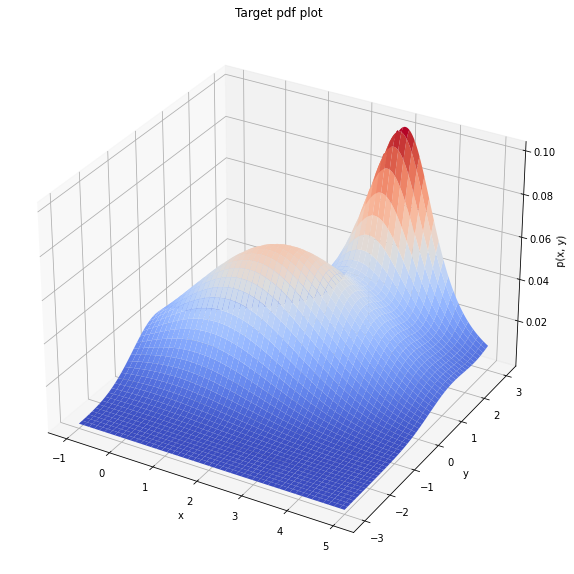

In [16]:
x = np.linspace(-1,5,500)
y = np.linspace(-3,3,500)

xx, yy = np.meshgrid(x, y)
pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy
pos.reshape(x.shape[0] * y.shape[0], 2)

zz = TargetMixture().pdf(pos)
    
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, zz, cmap='coolwarm')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('p(x, y)')
    
ax.set_title('Target pdf plot')

plt.show()

Finally, complete `metropolis_hastings` function:

In [17]:
def metropolis_hastings(
    target_distribution: Distribution,
    proposal_distribution: Type[Distribution],
    start_value: np.ndarray,
    num_samples: int = 5000,
    burn_in: int = 100) -> np.ndarray:
    
    """
    target_distribution: instance of Distribution class withpdf method (maybe up to a constant multiplier)
    proposal_distribution: distribution we can sample from
    start_value: x^0 in our Markov chain
    num_samples: desired number of samples from target
    burn_in: the amount of iterations we do before starting to save the samples
    
    return: np.ndarray of samples
    """
    
    samples = []
    
    proposal_t1 = proposal_distribution(start_value)
    
    x_t = proposal_t1.sample() 
    for x in range(burn_in + num_samples):
        if x > burn_in:
            samples.append(x_t)
        
        proposal_t1 = proposal_distribution(x_t)
        
        x_t1 = proposal_t1.sample()
        proposal_inv = proposal_distribution(x_t1)
        
        current_pi = target_distribution.pdf(x_t1)
        prev_pi = target_distribution.pdf(x_t)
        
        current_q = proposal_t1.pdf(x_t1)   # q(x^*|x_t)
        prev_q = proposal_inv.pdf(x_t)
        
        hastings_ratio = (current_pi * prev_q) / (prev_pi * current_q)
        
        acceptance_ratio = min(1, hastings_ratio)
        take_new_point = np.random.binomial(1, acceptance_ratio) 

        if take_new_point:
            x_t = x_t1
            proposal_t = proposal_t1
        
    return np.array(samples)

In [18]:
np.random.seed(42)

cov_samples = metropolis_hastings(TargetMixture(), CovNormal2D, 
                                  np.zeros(2), num_samples=5000, burn_in=100)
sine_samples = metropolis_hastings(TargetMixture(), SineNormal2D, 
                                   np.zeros(2), num_samples=5000, burn_in=100)

Finally, let us plot what we have obtained

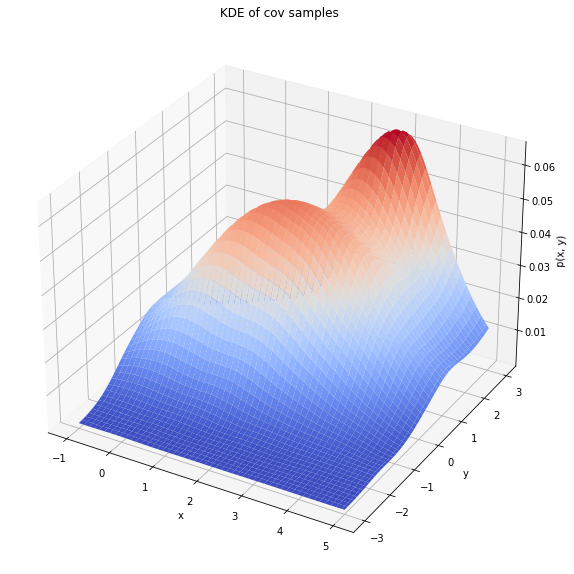

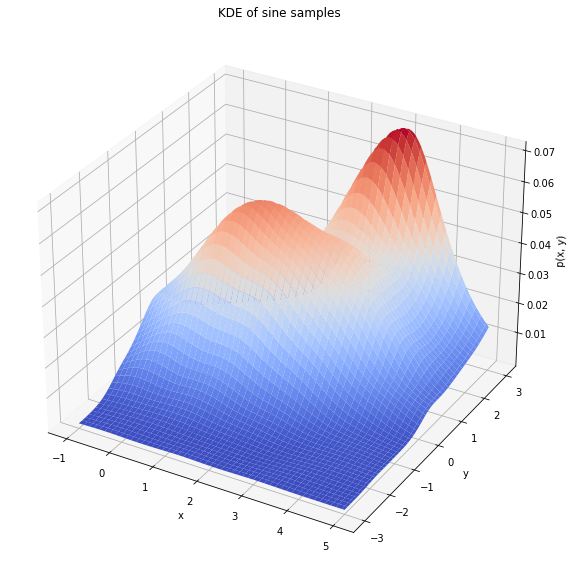

In [19]:
### plot cov samples
x = cov_samples[:, 0]
y = cov_samples[:, 1]

xx, yy = np.mgrid[-1:5:100j, -3:3:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(13, 10))

ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, zz, cmap='coolwarm')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('p(x, y)')
    
ax.set_title('KDE of cov samples')


### plot sine samples
x = sine_samples[:, 0]
y = sine_samples[:, 1]

xx, yy = np.mgrid[-1:5:100j, -3:3:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)

new_figure = plt.figure(figsize=(13, 10))
new_ax = plt.axes(projection='3d')

new_ax.plot_surface(xx, yy, zz, cmap='coolwarm')

new_ax.set_xlabel('x')
new_ax.set_ylabel('y')
new_ax.set_zlabel('p(x, y)')
    
new_ax.set_title('KDE of sine samples')

plt.show()

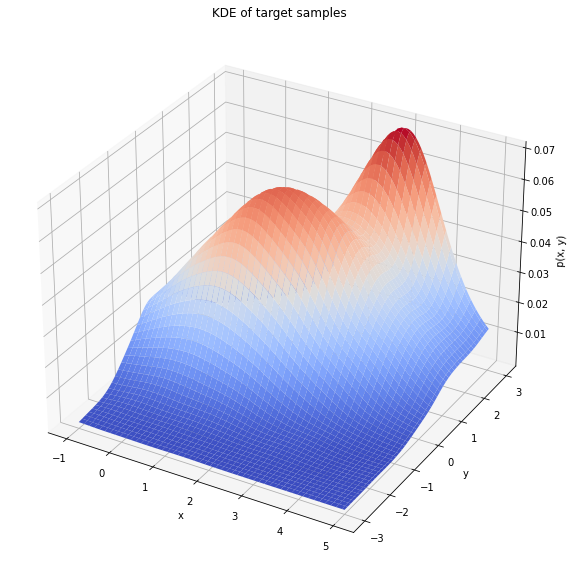

In [20]:
### plot real samples
np.random.seed(12)

target_samples = TargetMixture().sample(5000)

x = target_samples[:, 0]
y = target_samples[:, 1]

xx, yy = np.mgrid[-1:5:100j, -3:3:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)

new_figure = plt.figure(figsize=(13, 10))
new_ax = plt.axes(projection='3d')

new_ax.plot_surface(xx, yy, zz, cmap='coolwarm')

new_ax.set_xlabel('x')
new_ax.set_ylabel('y')
new_ax.set_zlabel('p(x, y)')
    
new_ax.set_title('KDE of target samples')

plt.show()

As we can see KDE of real samples is pretty simillar to the ones from our MCMC algorithm.

## 4. Gibbs Sampler

Suppose we need to draw samples from some multi-dimensional distribution $\pi(x)=\pi(x_1, \dotsc, x_p)$. Gibbs sampling is a variant of single component Metropolis-Hastings that uses full conditional distributions for the proposal distribution for each component. Given a target density $\pi$ we cycle through sampling from $\pi(x_i|x_{-i})$ to update the $i$th component. However unlike Metropolis-Hastings, there is no accept/reject step. We always accept, for reasons that will be detailed below.

Generation of sample $x^{n+1}$ on step $n+1$ works the following way:
$$x^{n+1}_1\sim\pi(x_1|x^n_2, x^n_3,\dotsc,x^n_p)$$
$$x^{n+1}_2\sim\pi(x_2|x^{n+1}_1, x^n_3, x^n_4,\dotsc,x^n_p)$$
$$\dotsc$$
$$x^{n+1}_p\sim\pi(x_p|x^{n+1}_1, x^{n+1}_2,\dotsc,x^{n+1}_{p-1})$$
So, at each step of the sampling we use the most recent values of all the other components in the full conditional distribution.

We can consider the set of conditionals distribution for sample components described above to be transitional probability in a Markov chain. Now let's prove that distribution $\pi(x)$ is invariant for this Markov chain.

**Proof**

We will use induction method for our prove. Suppose we generate $x_k\sim\pi(x_k|x_{-k})$. According to the induction hypothethis, $x_{-k}\sim\pi(x_{-k})$ - all the previous components are generated from the given distribution. Then joint configuration $(x_k, x_{-k})\sim\pi(x_k|x_{-k})\pi(x_{-k})=\pi(x_k, x_{-k})=\pi(x)$, meaning we still generate from the given distribution and we have proved the induction step.

An interesting case to discuss is a common mistake that is made when applying the Gibbs sampling. Instead of making step
$$x^{n+1}_k\sim\pi(x_k|x^{n+1}_1,\dotsc,x^{n+1}_{i-1}, x^n_{i+1},\dotsc,x^n_p)$$
one can make
$$x^{n+1}_k\sim\pi(x_k|x^n_1,\dotsc,x^n_{i-1}, x^n_{i+1},\dotsc,x^n_p)$$
which means using only the previous iteration results, and not the intermediate from the current iteration. This leads to a transitional probability equal to
$$q(x|x^n)=\prod\limits_{k=1}^p\pi(x_k|x^n_{-k}) \:\:\: (*)$$
It can be shown that distribution $\pi(x)$ is not invariant for such Markov chain. However, we can still do our sampling - we have to refer back to the Metropolis-Hastings scheme and use distribution $(*)$ as the $q(x|x^n)$ distribution used to sample $x^*$.

**Example (simple) - Bivariate Normal Distribution**

Suppose we want to simulate from a bivariate Normal distribution with mean $\mu=(\mu_1, \mu_2)$ and covariance matrix
$$\Sigma=
\begin{pmatrix}
\sigma_1^2 & \rho \sigma_1 \sigma_2 \\
\rho \sigma_1 \sigma_2 & \sigma_2^2
\end{pmatrix}$$
We could use the approach discussed earlier in section 3 but let's show how Gibbs sampling works in this easy case.

After the $n$th iteration we have vector $(x_n, y_n)$ and we update it the following way:
$$x_{n+1}\sim\mathcal{N}(\mu_1+\rho\frac{\sigma_1}{\sigma_2}(y_n-\mu_2),\: \sigma_1^2(1-\rho))$$
$$y_{n+1}\sim\mathcal{N}(\mu_2+\rho\frac{\sigma_2}{\sigma_1}(x_{n+1}-\mu_1),\: \sigma_2^2(1-\rho))$$

**Gibbs sampling code**

In [21]:
def get_conditional_dist(joint_mu, joint_cov, var_index):
    '''Returns the conditional distribution given the joint distribution and which variable
    the conditional probability should use.
    Right now this only works for 2-variable joint distributions.
    
      joint_mu: joint distribution's mu
      joint_cov: joint distribution's covariance
      var_index: index of the variable in the joint distribution. Everything else will be 
        conditioned on. For example, if the joint distribution p(a, b, c) has mu [mu_a, mu_b, mu_c],
        to get p(c | a, b), use var_index = 2.
      
    returns:
      a function that can sample from the univariate conditional distribution
    '''
    assert joint_mu.shape[0] == 2, 'Sorry, this function only works for 2-dimensional joint distributions right now'
    a = joint_mu[var_index]
    b = joint_mu[~var_index]
    
    A = joint_cov[var_index, var_index]
    B = joint_cov[~var_index, ~var_index]
    C = joint_cov[var_index, ~var_index]
    
    # we're dealing with one dimension so
    B_inv = 1/B
    
    # Return a function that can sample given a value of g
    def dist(g):
        # a + C*B^{-1}(g - b)
        mu = a + C * B_inv * (g - b)
        # A - C * B^{-1} * C^T
        cov = A - B_inv * C * C
        return np.sqrt(cov) * np.random.randn(1) + mu
    
    return dist

In [22]:
def gibbs_sampling(
    start_value: np.ndarray,
    joint_mu: np.ndarray,
    joint_cov: np.ndarray,
    d: int = 2,
    num_samples: int = 5000,
    burn_in: int = 100) -> np.ndarray:
    
    """
    joint_mu: mean of the desired normal
    joint_cov: cov matrix of the desired normal
    start_value: x^0 in our Markov chain
    num_samples: desired number of samples from target
    burn_in: the amount of iterations we do before starting to save the samples
    
    return: np.ndarray of samples from multidimensional normal
    """
    
    samples = []
    D = len(start_value)    # dimensionality of distribution
    
    univariate_conditionals = [get_conditional_dist(joint_mu, joint_cov, d) for d in range(D)]
    
    x_t = start_value    # start with arbitrary sample
    
    for i in range(1, burn_in + num_samples + 1):
        if i > burn_in:
            samples.append(x_t.copy())
        
        # first set this sample equal to the previous sample
        x_t1 = x_t
        
        # now iterate over dimensions to update the dimension whose turn it is using the conditional distribution
        # pass in all dimension from the previous sample except this dimension

        for d in range(D):
            x_t1[d] = univariate_conditionals[d](x_t[~d])
            x_t[d] = x_t1[d]

        
    return np.array(samples)

In [23]:
np.random.seed(12)

joint_mu = np.ones(2)
joint_cov = np.array([[3, 1], [1, 2]])

gibbs_samples = gibbs_sampling(start_value=np.zeros(2),
                               joint_mu=joint_mu,
                               joint_cov=joint_cov,
                               num_samples=1000, burn_in=100)

real_samples = st.multivariate_normal(joint_mu, joint_cov).rvs(1000) 

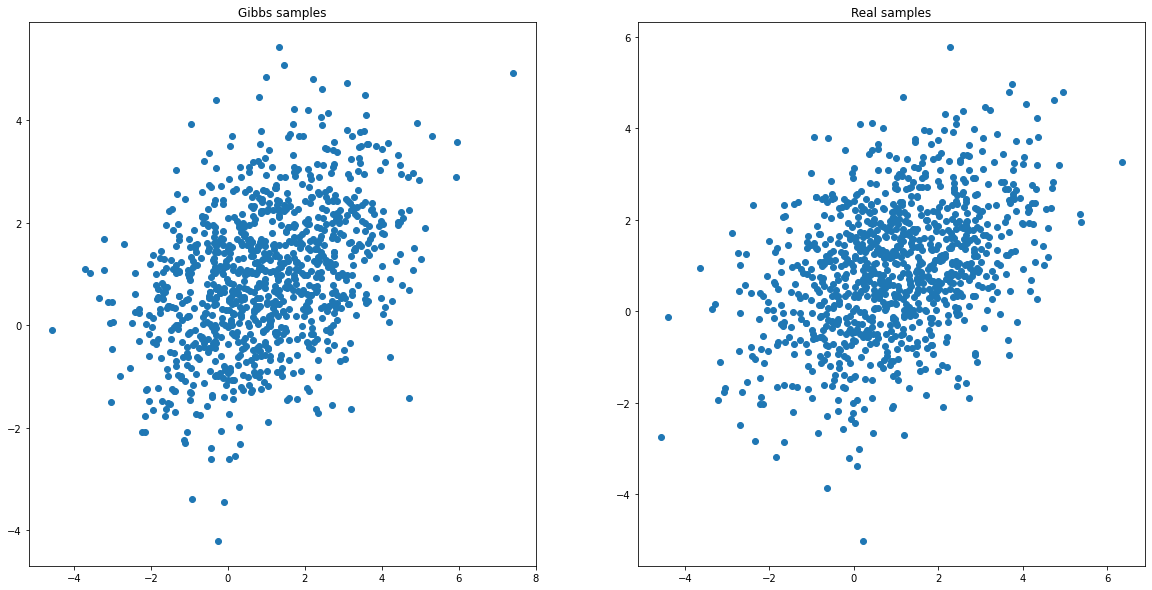

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.scatter(gibbs_samples[:, 0], gibbs_samples[:, 1])
ax1.set_title('Gibbs samples')

ax2.scatter(real_samples[:, 0], real_samples[:, 1])
ax2.set_title('Real samples')

plt.show()

## 5. References

1. https://www.stat.umn.edu/geyer/f05/8931/n1998.pdf
2. https://www.robots.ox.ac.uk/~fwood/teaching/C19_hilary_2015_2016/mcmc.pdf
3. https://arxiv.org/pdf/math/0404033.pdf
4. https://drive.google.com/file/d/1AQHXFYFA7V-Kt67lJGeEmzxdNkTk7KYJ/view